# Projet Data Science : Prédiction des Dépenses de Santé (MEPS)

**Auteurs :** Amandine Perret et Thomas Pradeau

## 1. Introduction et Objectifs

Ce projet vise à prédire le profil de dépenses de santé (Faible, Moyen, Élevé) d'individus pour l'année 2023, en se basant sur leurs données socio-démographiques et leur historique de santé de 2022.

**Données utilisées :** *Medical Expenditure Panel Survey (MEPS)*.
* **Taille :** > 8000 individus.
* **Variables :** > 10 variables explicatives (Dépenses passées, Âge, Revenu, Éducation, etc.).
* **Problématique :** Classification Supervisée Multi-classes.

**Défi Principal :** Le déséquilibre des classes. La majorité des individus ont des dépenses "Faibles", ce qui rend la détection des profils "Élevés" (les plus critiques) difficile pour les algorithmes classiques.

**Métrique d'évaluation :** Nous utiliserons le **Macro F1-Score** plutôt que l'Accuracy globale, car il donne le même poids à chaque classe, nous empêchant d'ignorer les classes minoritaires.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn & Tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

# Configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print("Librairies chargées avec succès.")

Librairies chargées avec succès.


## 2. Préparation des Données

Nous chargeons le jeu de données nettoyé et procédons à la séparation en jeu d'entraînement (Train) et jeu de test (Test).

Nous utilisons un `random_state=42` fixe pour garantir que tous les modèles soient comparés sur exactement les mêmes individus.

In [8]:
# Chargement
df = pd.read_csv("all_expenses_agrege_profil.csv")

# Séparation Cible / Features
y = df["profil"]
X = df.drop(["TOTEXP23", "profil", "profil_label", "DUPERSID"], axis=1, errors="ignore")

# Encodage de sécurité pour XGBoost (0, 1, 2)
le = LabelEncoder()
y = le.fit_transform(y)

# Split Train/Test (Fixé à 42 pour comparabilité parfaite)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Train shape : {X_train.shape}")
print(f"Test shape  : {X_test.shape}")
print(f"Distribution classes Train : {np.bincount(y_train)} (0=Faible, 1=Moyen, 2=Élevé)")
print(f"Distribution classes Test : {np.bincount(y_test)} (0=Faible, 1=Moyen, 2=Élevé)")

Train shape : (16653, 13)
Test shape  : (5551, 13)
Distribution classes Train : [15970   530   153] (0=Faible, 1=Moyen, 2=Élevé)
Distribution classes Test : [5323  177   51] (0=Faible, 1=Moyen, 2=Élevé)


In [9]:
# A gérer mieux plus tard :

print("--- Correction Rapide des Valeurs Négatives ---")

# Identification des colonnes
num_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_vars = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Séparation pour Log-transform (évite log sur valeurs négatives comme 'tendance')
vars_negative = [col for col in num_vars if "tendance" in col]
vars_positive = [col for col in num_vars if col not in vars_negative]

# 1. Nettoyage de X_train
for col in vars_positive:
    # Remplacer toute valeur négative par 0 (le min est 0)
    # np.clip(a, a_min, a_max) borne les valeurs entre a_min et a_max.
    # Ici, on borne la valeur minimale à 0.
    
    # Correction in-place (ou affectation) pour X_train
    if col in X_train.columns:
        # Vérifie si la colonne contient des valeurs négatives avant de clipper
        if (X_train[col] < 0).any():
             X_train[col] = X_train[col].clip(lower=0)
             print(f"Correction appliquée à X_train['{col}']: Min est maintenant {X_train[col].min()}.")

# 2. Nettoyage de X_test
for col in vars_positive:
    # La même correction doit être appliquée au jeu de test
    if col in X_test.columns:
        if (X_test[col] < 0).any():
             X_test[col] = X_test[col].clip(lower=0)
             print(f"Correction appliquée à X_test['{col}']: Min est maintenant {X_test[col].min()}.")


print("--- Nettoyage Terminé ---")


--- Correction Rapide des Valeurs Négatives ---
Correction appliquée à X_train['Total_home']: Min est maintenant 0.0.
Correction appliquée à X_test['Total_home']: Min est maintenant 0.0.
--- Nettoyage Terminé ---


## 3. Pipelines de Prétraitement

Nous définissons deux stratégies de prétraitement distinctes selon les besoins des algorithmes :

1.  **Pipeline Scaled (Pour Modèles Linéaires & NN) :**
    * Imputation des valeurs manquantes.
    * **Log-transformation** (`np.log1p`) pour les variables de dépenses (très asymétriques).
    * **StandardScaler** pour mettre toutes les variables à la même échelle (indispensable pour SVM et NN).

2.  **Pipeline Tree (Pour Arbres de Décision) :**
    * Imputation simple.
    * Pas de scaling nécessaire (les arbres gèrent naturellement les échelles différentes).

In [10]:
# Identification des colonnes
num_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_vars = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Séparation pour Log-transform (évite log sur valeurs négatives comme 'tendance')
vars_negative = [col for col in num_vars if "tendance" in col]
vars_positive = [col for col in num_vars if col not in vars_negative]

# --- PIPELINE A : Pour Modèles Linéaires & NN (Besoin de Scaling + Log) ---
log_transformer = FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one')

preproc_scaled = ColumnTransformer(
    transformers=[
        ("num_pos", Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0)), 
                              ("log", log_transformer), 
                              ("scaler", StandardScaler())]), vars_positive),
        ("num_neg", Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0)), 
                              ("scaler", StandardScaler())]), vars_negative),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ]
)

# --- PIPELINE B : Pour Arbres (RF, XGB) (Pas besoin de Scaling) ---
preproc_tree = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="constant", fill_value=0), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ]
)

# Dictionnaire pour stocker les scores finaux
final_scores = {}

## 4. Modélisation

### 4.1. Modèle Interprétable : Régression Logistique
C'est notre "Baseline". Nous testons l'impact du paramètre `class_weight='balanced'` pour voir si le modèle linéaire peut gérer le déséquilibre.

In [11]:
print("\n=== ENTRAÎNEMENT RÉGRESSION LOGISTIQUE ===")

pipe_logreg = Pipeline([
    ('preproc', preproc_scaled),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42, solver='lbfgs'))
])

params_logreg = {
    'logreg__C': [0.1, 1, 10],
    'logreg__class_weight': [None, 'balanced'] # Test gestion déséquilibre
}

grid_logreg = GridSearchCV(pipe_logreg, params_logreg, cv=5, scoring="f1_macro", n_jobs=-1)
grid_logreg.fit(X_train, y_train)



=== ENTRAÎNEMENT RÉGRESSION LOGISTIQUE ===


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'logreg__C': [0.1, 1, ...], 'logreg__class_weight': [None, 'balanced']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_pos', ...), ('num_neg', ...), ...]"


In [12]:
y_pred_logreg = grid_logreg.predict(X_test)
score_logreg = f1_score(y_test, y_pred_logreg, average='macro')
final_scores["Logistic Regression"] = score_logreg

print(f"Meilleurs params : {grid_logreg.best_params_}")
print(f"Macro F1 : {score_logreg:.4f}")

Meilleurs params : {'logreg__C': 1, 'logreg__class_weight': 'balanced'}
Macro F1 : 0.3325


#### Interprétation des Coefficients
Analyse des variables qui influencent le plus la probabilité d'appartenir à la classe **"Élevé"** (Profil à risque).

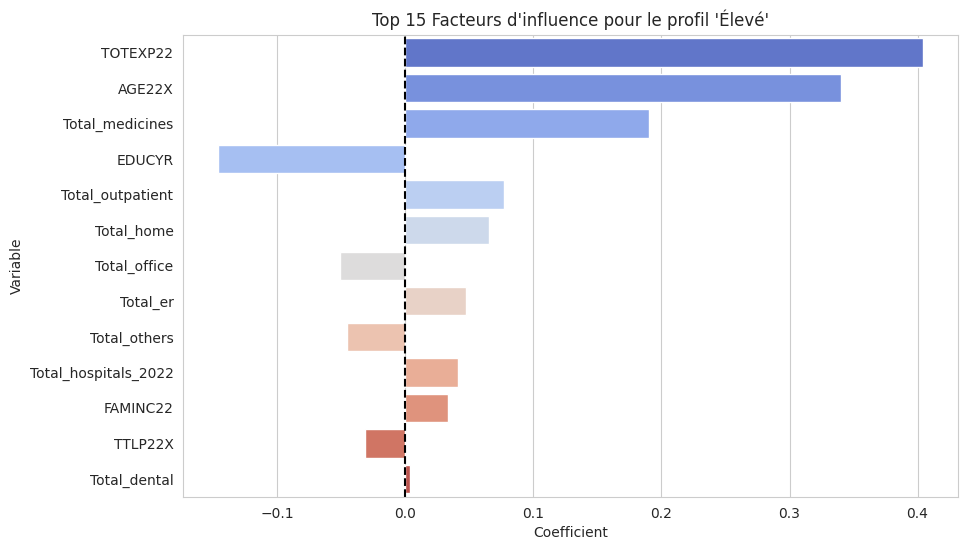

In [13]:
# Récupération du modèle
best_model_log = grid_logreg.best_estimator_.named_steps['logreg']
preproc_log = grid_logreg.best_estimator_.named_steps['preproc']

# Récupération des noms de variables (Fonctionne maintenant grâce au fix précédent)
feature_names = preproc_log.get_feature_names_out()

# Nettoyage des préfixes
clean_names = [n.replace('num_pos__', '').replace('num_neg__', '').replace('cat__', '') for n in feature_names]

# Coefficients pour la classe 2 (Élevé)
coefs_high = best_model_log.coef_[2]

# DataFrame et Plot
df_coefs = pd.DataFrame({'Variable': clean_names, 'Coefficient': coefs_high})
df_coefs['Abs_Coeff'] = df_coefs['Coefficient'].abs()
df_coefs = df_coefs.sort_values(by='Abs_Coeff', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Variable', data=df_coefs, palette='coolwarm')
plt.title("Top 15 Facteurs d'influence pour le profil 'Élevé'")
plt.axvline(0, color='black', linestyle='--')
plt.show()

### 4.2. Support Vector Machine (Linear SVM)
Nous utilisons un SVM linéaire (`LinearSVC`), souvent efficace en haute dimension après encodage OneHot.

In [14]:
print("\n=== ENTRAÎNEMENT SVM ===")

pipe_svm = Pipeline([
    ('preproc', preproc_scaled),
    ('svc', LinearSVC(max_iter=5000, dual=False, random_state=42))
])

params_svm = {
    'svc__C': [0.1, 1, 10],
    'svc__class_weight': [None, 'balanced']
}

grid_svm = GridSearchCV(pipe_svm, params_svm, cv=5, scoring="f1_macro", n_jobs=-1)
grid_svm.fit(X_train, y_train)



=== ENTRAÎNEMENT SVM ===


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__class_weight': [None, 'balanced']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_pos', ...), ('num_neg', ...), ...]"


In [15]:
y_pred_svm = grid_svm.predict(X_test)
score_svm = f1_score(y_test, y_pred_svm, average='macro')
final_scores["SVM"] = score_svm

print(f"Meilleurs params : {grid_svm.best_params_}")
print(f"Macro F1 : {score_svm:.4f}")

Meilleurs params : {'svc__C': 1, 'svc__class_weight': 'balanced'}
Macro F1 : 0.3655


### 4.3. Réseau de Neurones (Deep Learning)
Nous construisons un réseau Dense avec l'architecture recommandée dans le cours :
* **He Initialization** pour les poids.
* **Batch Normalization** pour la stabilité.
* **Dropout** pour la régularisation.

Le déséquilibre des classes est critique. Au lieu de fixer des poids arbitraires, nous allons tester plusieurs configurations de pénalités (`class_weight`) pour voir laquelle maximise notre **Macro F1-Score**.

Nous testons :
1.  **Standard :** Pas de poids (1, 1, 1).
2.  **Douce :** Petite pénalité (1, 2, 3).
3.  **Forte :** Pénalité moyenne (1, 5, 10).
4.  **Extrême :** Pénalité très forte sur les classes rares (1, 10, 50).

In [16]:
print("=== 3a. Optimisation des Poids (NN) ===")

# Préparation données
X_train_nn = preproc_scaled.fit_transform(X_train).astype('float32')
X_test_nn = preproc_scaled.transform(X_test).astype('float32')
input_shape = X_train_nn.shape[1]

# Liste de poids à tester
weight_candidates = [
    {0: 1.0, 1: 1.0, 2: 1.0},   # Standard
    {0: 1.0, 1: 2.0, 2: 3.0},   # Doux
    {0: 1.0, 1: 5.0, 2: 10.0},  # Fort
    {0: 1.0, 1: 10.0, 2: 50.0}  # Extrême
]

def build_nn_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal', input_dim=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

best_weight = None
best_score = 0

for weights in weight_candidates:
    model_temp = build_nn_model()
    # Entraînement rapide (20 epochs, verbose=0 pour ne pas polluer)
    model_temp.fit(X_train_nn, y_train, epochs=20, batch_size=64, verbose=0, class_weight=weights)
    
    preds = np.argmax(model_temp.predict(X_test_nn, verbose=0), axis=1)
    score = f1_score(y_test, preds, average='macro')
    print(f"Poids {weights} -> Macro F1: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_weight = weights

print(f"\n>>> MEILLEURE CONFIGURATION RETENUE : {best_weight}")

=== 3a. Optimisation des Poids (NN) ===


2025-12-13 14:17:22.524596: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Poids {0: 1.0, 1: 1.0, 2: 1.0} -> Macro F1: 0.3263
Poids {0: 1.0, 1: 2.0, 2: 3.0} -> Macro F1: 0.3263
Poids {0: 1.0, 1: 5.0, 2: 10.0} -> Macro F1: 0.4229
Poids {0: 1.0, 1: 10.0, 2: 50.0} -> Macro F1: 0.3651

>>> MEILLEURE CONFIGURATION RETENUE : {0: 1.0, 1: 5.0, 2: 10.0}


In [17]:
print("=== 3b. Entraînement Final NN ===")

model_nn = build_nn_model()
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement complet avec le meilleur poids
history = model_nn.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    class_weight=best_weight,
    callbacks=[early_stop],
    verbose=0 
)

# Sauvegarde du score
y_pred_nn = np.argmax(model_nn.predict(X_test_nn), axis=1)
score_nn = f1_score(y_test, y_pred_nn, average='macro')
final_scores["Neural Network"] = score_nn

print(f"NN Terminé. Macro F1 Final : {score_nn:.4f}")


=== 3b. Entraînement Final NN ===


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
NN Terminé. Macro F1 Final : 0.3707


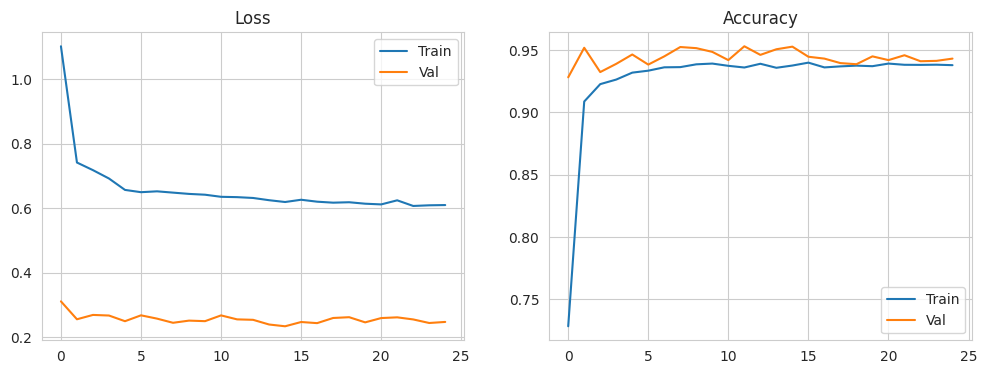

In [18]:
# Courbe d'apprentissage 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

### 4.4. Méthodes Ensemblistes
Ces méthodes sont généralement l'état de l'art pour les données tabulaires.
1.  **Random Forest (Bagging) :** Moyenne d'arbres indépendants.
2.  **XGBoost (Boosting) :** Construction séquentielle d'arbres correcteurs.

In [19]:
print("\n=== ENTRAÎNEMENT RANDOM FOREST ===")

pipe_rf = Pipeline([
    ('preproc', preproc_tree),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

params_rf = {
    'rf__n_estimators': [200],
    'rf__max_depth': [10, 20],
    'rf__class_weight': ['balanced', 'balanced_subsample'] # Clé pour RF
}

grid_rf = GridSearchCV(pipe_rf, params_rf, cv=3, scoring="f1_macro", n_jobs=-1)
grid_rf.fit(X_train, y_train)

y_pred_rf = grid_rf.predict(X_test)
score_rf = f1_score(y_test, y_pred_rf, average='macro')
final_scores["Random Forest"] = score_rf

print(f"Meilleurs params RF : {grid_rf.best_params_}")
print(f"Macro F1 RF : {score_rf:.4f}")




=== ENTRAÎNEMENT RANDOM FOREST ===
Meilleurs params RF : {'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 10, 'rf__n_estimators': 200}
Macro F1 RF : 0.4084


In [20]:
print("\n=== ENTRAÎNEMENT XGBOOST ===")

pipe_xgb = Pipeline([
    ('preproc', preproc_tree),
    ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1))
])

params_xgb = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(pipe_xgb, params_xgb, cv=3, scoring="f1_macro", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

y_pred_xgb = grid_xgb.predict(X_test)
score_xgb = f1_score(y_test, y_pred_xgb, average='macro')
final_scores["XGBoost"] = score_xgb

print(f"Meilleurs params XGB : {grid_xgb.best_params_}")
print(f"Macro F1 XGB : {score_xgb:.4f}")


=== ENTRAÎNEMENT XGBOOST ===
Meilleurs params XGB : {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Macro F1 XGB : 0.3262


## 5. Synthèse et Conclusion

Nous comparons ici les performances de tous les modèles testés.
Le **Macro F1-Score** est notre juge de paix pour déterminer quel modèle gère le mieux le compromis entre les classes majoritaires et minoritaires.

Le tableau et le graphique ci-dessous résument les performances. Nous avons défini un **seuil critique de 0.30** pour le Macro F1-Score.
* En dessous de 0.30, le modèle est équivalent à un modèle naïf qui prédit toujours la classe majoritaire ("Faible").
* Au-dessus de 0.30, le modèle commence à capturer de l'information utile sur les profils à risque ("Moyen" et "Élevé").


TABLEAU RÉCAPITULATIF
                Modèle  Macro F1
3        Random Forest  0.408377
2       Neural Network  0.370673
1                  SVM  0.365542
0  Logistic Regression  0.332537
4              XGBoost  0.326219


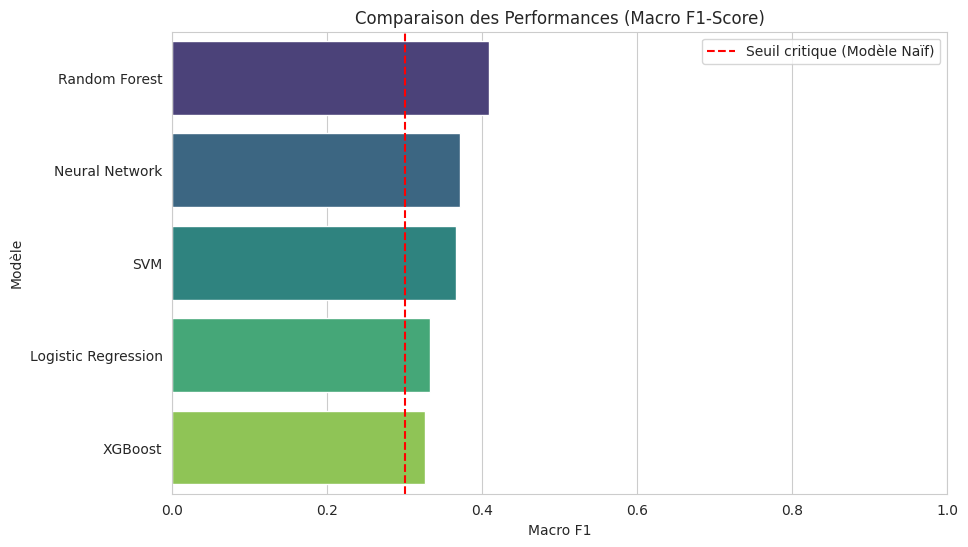

In [21]:
print("\n" + "="*50)
print("TABLEAU RÉCAPITULATIF")
print("="*50)

results_df = pd.DataFrame(list(final_scores.items()), columns=['Modèle', 'Macro F1'])
results_df = results_df.sort_values(by='Macro F1', ascending=False)
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Macro F1', y='Modèle', data=results_df, palette='viridis')
plt.title('Comparaison des Performances (Macro F1-Score)')
plt.axvline(x=0.3, color='r', linestyle='--', label='Seuil critique (Modèle Naïf)')
plt.xlim(0, 1.0)
plt.legend()
plt.show()


>>> MEILLEUR MODÈLE : Random Forest


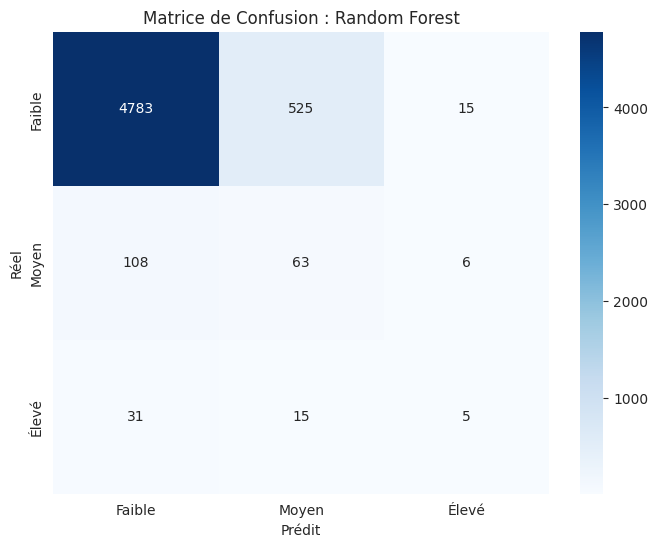


Détails par classe :
              precision    recall  f1-score   support

      Faible       0.97      0.90      0.93      5323
       Moyen       0.10      0.36      0.16       177
       Élevé       0.19      0.10      0.13        51

    accuracy                           0.87      5551
   macro avg       0.42      0.45      0.41      5551
weighted avg       0.94      0.87      0.90      5551



In [22]:
# Focus sur le champion
best_model_name = results_df.iloc[0]['Modèle']
print(f"\n>>> MEILLEUR MODÈLE : {best_model_name}")

# Récupération des prédictions du champion
if best_model_name == "Logistic Regression": y_final = y_pred_logreg
elif best_model_name == "SVM": y_final = y_pred_svm
elif best_model_name == "Neural Network": y_final = y_pred_nn
elif best_model_name == "Random Forest": y_final = y_pred_rf
else: y_final = y_pred_xgb

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_final), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faible', 'Moyen', 'Élevé'], yticklabels=['Faible', 'Moyen', 'Élevé'])
plt.title(f'Matrice de Confusion : {best_model_name}')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()

print("\nDétails par classe :")
print(classification_report(y_test, y_final, target_names=['Faible', 'Moyen', 'Élevé']))